Почему **нейронки**?
При подготовке работы было прочитано несколько статей:
1.   https://realpython.com/python-nltk-sentiment-analysis/
2.   https://databaytoday.data.blog/2020/01/31/sentiment-analysis-imdb-movie-review-classification-using-nltk-and-random-forest-classifier/
3. https://colab.research.google.com/drive/1t-NJadXsPTDT6EWIR0PRzpn5o8oMHzp3?usp=sharing#scrollTo=oB-ikgCN77wP

Предлагаются подходы на основе неглубоких моделей, однако их точность на 20-25% ниже нейросетевых. Именно поэтому используется данный подход на основе pytorch

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
!pip install datasets transformers huggingface_hub
!apt-get install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [ ]:
from datasets import load_dataset
imdb = load_dataset("imdb")

In [ ]:
small_train_dataset = imdb["train"].shuffle(seed=42).select([i for i in list(range(3000))])
small_test_dataset = imdb["test"].shuffle(seed=42).select([i for i in list(range(300))])
print(small_train_dataset[0])
print(small_test_dataset[0])

{'text': 'There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. Fortier\'s plot are far more complicated... Fortier looks more like Prime Suspect, if we have to spot similarities... The main character is weak and weirdo, but have "clairvoyance". People like to compare, to judge, to evaluate. How about just enjoying? Funny thing too, people writing Fortier looks American but, on the other hand, arguing they prefer American series (!!!). Maybe it\'s the language, or the spirit, but I think this series is more English than American. By the way, the actors are really good and funny. The acting is not superficial at all...', 'label': 1}
{'text': "<br /><br />When I unsuspectedly rented A Thousand Acres, I thought I was in for an entertaining King Lear story and of course Michelle Pfeiffer was in it, so what could go wrong?<br /><br />Very quickly, 

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", model_max_length=512)

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=512)

tokenized_train = small_train_dataset.map(preprocess_function, batched=True)
tokenized_test = small_test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
model.config.max_position_embeddings

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


512

In [ ]:
import numpy as np
from datasets import load_metric

def compute_metrics(eval_pred):
    load_accuracy = load_metric("accuracy")
    load_f1 = load_metric("f1")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
    return {"accuracy": accuracy, "f1": f1}

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
! pip install -U accelerate
! pip install -U transformers

In [ ]:
from transformers import TrainingArguments, Trainer

repo_name = "finetuning-sentiment-model-3000-samples"

training_args = TrainingArguments(
    output_dir=repo_name,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    save_strategy="epoch",
    push_to_hub=True,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Step,Training Loss


TrainOutput(global_step=376, training_loss=0.2877835821598134, metrics={'train_runtime': 301.1165, 'train_samples_per_second': 19.926, 'train_steps_per_second': 1.249, 'total_flos': 782725021021056.0, 'train_loss': 0.2877835821598134, 'epoch': 2.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.34896573424339294,
 'eval_accuracy': 0.8666666666666667,
 'eval_f1': 0.870967741935484,
 'eval_runtime': 7.1647,
 'eval_samples_per_second': 41.872,
 'eval_steps_per_second': 2.652,
 'epoch': 2.0}

In [ ]:
trainer.push_to_hub()

events.out.tfevents.1701553790.0c0696c858cc.3386.6:   0%|          | 0.00/457 [00:00<?, ?B/s]

'https://huggingface.co/Yunas2002/finetuning-sentiment-model-3000-samples/tree/main/'

In [ ]:
from transformers import pipeline

sentiment_model = pipeline(model="Yunas2002/finetuning-sentiment-model-3000-samples")

sentiment_model(["I love this move", "This movie sucks!"])

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

[{'label': 'LABEL_1', 'score': 0.9591391682624817},
 {'label': 'LABEL_0', 'score': 0.9630993604660034}]

In [ ]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")
data = ["I love you", "I hate you"]
sentiment_pipeline(data)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

[{'label': 'POSITIVE', 'score': 0.9998656511306763},
 {'label': 'NEGATIVE', 'score': 0.9991129040718079}]

In [ ]:
sentiment_pipeline = pipeline("sentiment-analysis")
data = ["I love you", "I hate you"]
specific_model = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis")
specific_model(data)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


[{'label': 'POS', 'score': 0.9916695356369019},
 {'label': 'NEG', 'score': 0.9806600213050842}]

In [ ]:
import requests
from bs4 import BeautifulSoup as bs

In [ ]:
url_Shawshank = "https://www.imdb.com/title/tt0111161/reviews?ref_=tt_urv"
url_Starwars = "https://www.imdb.com/title/tt2527338/reviews?ref_=tt_urv"
url_LApartment = "https://www.imdb.com/title/tt0115561/reviews?ref_=tt_urv"
url_Amundsen = "https://www.imdb.com/title/tt6054846/reviews?ref_=tt_urv"
url_Movie43 = "https://www.imdb.com/title/tt1333125/reviews?ref_=tt_urv"

urls = [url_Shawshank, url_Starwars, url_LApartment, url_Amundsen, url_Movie43]

In [ ]:
def get_content(url: str):
  page = requests.get(url)
  soup = bs(page.text, 'html.parser')
  soup.prettify()
  elems = soup.find_all("div", class_="imdb-user-review")
  reviews = [elem.find("div", class_="text").get_text() for elem in elems]
  score = [elem.find("div", class_="ipl-ratings-bar") for elem in elems]

  for i, e in enumerate(score):
    if e is None:
      del reviews[i]
      del score[i]

  score = [elem.find("span") for elem in score]
  score = [int(elem.find("span").get_text()) for elem in score]
  return reviews, score

In [ ]:
def to_abs_score(sentiment):
  if sentiment['label'] in ["LABEL_1", "POS", "POSITIVE"]:
    return sentiment['score']
  else:
    return -sentiment['score']

In [ ]:
from nltk import sent_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def get_sentiments(text: str):
  sentences = sent_tokenize(text)
  scores = list(map(sentiment_model, sentences))
  return [score[0] for score in scores]

def to_avg_abs(sentiments: list):
  abs_score = list(map(to_abs_score, sentiments))
  return sum(abs_score) / len(abs_score)

def to_avg_abs_list(sentiments_list: list):
  return list(map(to_avg_abs, sentiments_list))

In [ ]:
reviews, scores = zip(*map(get_content, urls))

In [ ]:
sentiments = [list(map(get_sentiments, review)) for review in reviews]

In [ ]:
abs_sentiments = []
for movie in sentiments:
  movie_scores = list(map(to_avg_abs, movie))
  abs_sentiments.append(movie_scores)

In [ ]:
abs_sentiments

[[0.41310481612498945,
  0.40887417395909625,
  0.15391174054914905,
  0.6577460646629334,
  0.9152390360832214,
  0.22700124606490135,
  0.6010335494171489,
  0.899215042591095,
  0.7454672574996948,
  0.6472529428345817,
  0.838185062011083,
  0.9648811936378479,
  0.6300991037312675,
  0.778236965338389,
  0.20056349890572683,
  0.7438822189966837,
  0.4748642643292745,
  0.7733200090272087,
  0.5388760089874267,
  0.9787138104438782,
  0.9841488003730774],
 [-0.1413333147344455,
  -0.404150128364563,
  -0.5632024624991039,
  -0.5840789993604024,
  -0.5689361333847046,
  -0.11903234124183655,
  -0.04147405349291288,
  -0.6932866222718183,
  -0.7925229668617249,
  -0.9734740704298019,
  -0.46496591303083634,
  -0.07435393333435059,
  0.04264632612466812,
  -0.5528286496798197,
  -0.14443421363830566,
  -0.38108666075600517,
  -0.07035059050509804,
  -0.4763436561281031,
  -0.41168795932422986,
  -0.977770189444224,
  -0.39127628207206727,
  -0.4770545244216919],
 [0.5332193076610565,

In [ ]:
from scipy.stats import pearsonr

Здесь под статистикой подразумевается коэффициент корелляции, а под p-value вероятность, что корелляция отсутствует

In [ ]:
pearsonr(abs_sentiments[0], scores[0]) # Корелляции нет

PearsonRResult(statistic=0.15281326576458285, pvalue=0.5084204102831371)

In [ ]:
pearsonr(abs_sentiments[1], scores[1]) # Умеренная

PearsonRResult(statistic=0.4827843850441806, pvalue=0.02285602785054377)

In [ ]:
pearsonr(abs_sentiments[2], scores[2]) # Высокая

PearsonRResult(statistic=0.8670451000203945, pvalue=1.553524719494756e-06)

In [ ]:
pearsonr(abs_sentiments[3], scores[3]) # Высокая

PearsonRResult(statistic=0.765016242603325, pvalue=0.00013577508246026998)

In [ ]:
pearsonr(abs_sentiments[4], scores[4]) # Высокая

PearsonRResult(statistic=0.6736688720755012, pvalue=0.0003077876079783261)

In [ ]:
from scipy.stats import f_oneway # Anova Test

In [ ]:
f_oneway(*scores)

F_onewayResult(statistic=26.326656911911574, pvalue=6.389789349821978e-15)

In [ ]:
f_oneway(*abs_sentiments)

F_onewayResult(statistic=21.610546797451004, pvalue=7.182628361940546e-13)

In [ ]:
import numpy as np

In [ ]:
# Проверим корелляцию на объединенной выборке
flatten_x = np.concatenate(scores)
flatten_y = np.concatenate(abs_sentiments)
pearsonr(flatten_x, flatten_y)

PearsonRResult(statistic=0.8137525750995094, pvalue=5.1086707253289247e-26)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
import seaborn as sns

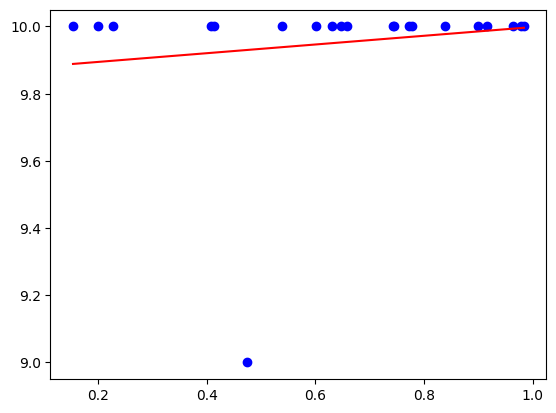

In [ ]:
reg = LinearRegression().fit(np.array(abs_sentiments[0]).reshape(-1, 1), np.array(np.array(scores[0])))
x = np.linspace(min(abs_sentiments[0]), max(abs_sentiments[0]), 10)
y = reg.coef_[0] * x + reg.intercept_
fig, ax = plt.subplots()
sns.lineplot(x=x, y=y, c="r")
ax.scatter(abs_sentiments[0], scores[0], c="b")

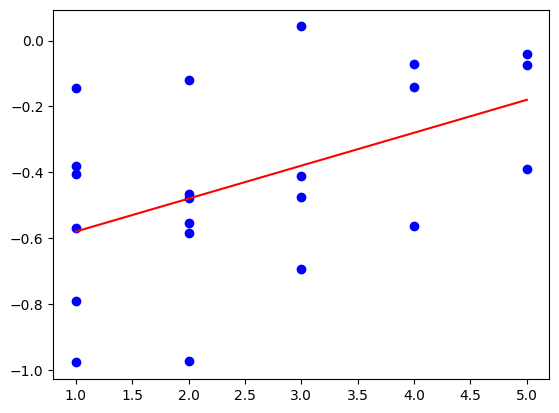

In [ ]:
reg = LinearRegression().fit(np.array(scores[1]).reshape(-1, 1), np.array(abs_sentiments[1]))
x = np.linspace(min(scores[1]), max(scores[1]), 10)
y = reg.coef_[0] * x + reg.intercept_
fig, ax = plt.subplots()
sns.lineplot(x=x, y=y, c="r")
ax.scatter(scores[1], abs_sentiments[1], c="b")

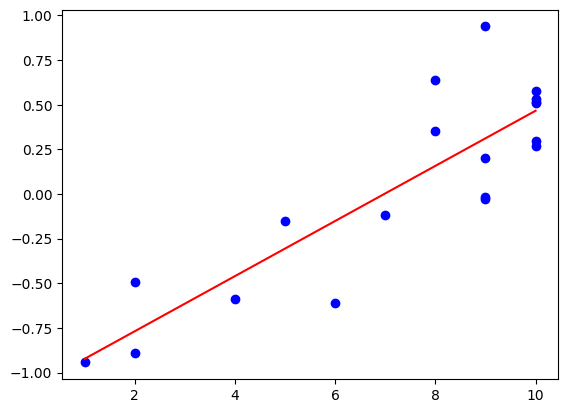

In [ ]:
reg = LinearRegression().fit(np.array(scores[2]).reshape(-1, 1), np.array(abs_sentiments[2]))
x = np.linspace(min(scores[2]), max(scores[2]), 10)
y = reg.coef_[0] * x + reg.intercept_
fig, ax = plt.subplots()
sns.lineplot(x=x, y=y, c="r")
ax.scatter(scores[2], abs_sentiments[2], c="b")

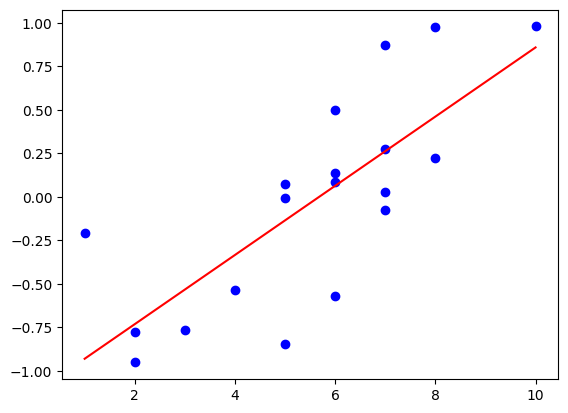

In [ ]:
reg = LinearRegression().fit(np.array(scores[3]).reshape(-1, 1), np.array(abs_sentiments[3]))
x = np.linspace(min(scores[3]), max(scores[3]), 10)
y = reg.coef_[0] * x + reg.intercept_
fig, ax = plt.subplots()
sns.lineplot(x=x, y=y, c="r")
ax.scatter(scores[3], abs_sentiments[3], c="b")

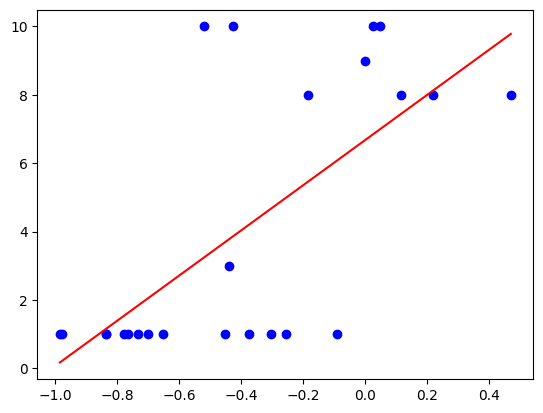

In [ ]:
reg = LinearRegression().fit(np.array(abs_sentiments[4]).reshape(-1, 1), np.array(np.array(scores[4])))
x = np.linspace(min(abs_sentiments[4]), max(abs_sentiments[4]), 10)
y = reg.coef_[0] * x + reg.intercept_
fig, ax = plt.subplots()
sns.lineplot(x=x, y=y, c="r")
ax.scatter(abs_sentiments[4], scores[4], c="b")

In [ ]:
reg = LinearRegression().fit(flatten_x.reshape(-1, 1), flatten_y)

In [ ]:
x = np.linspace(min(flatten_x), max(flatten_x), 10)
y = reg.coef_[0] * x + reg.intercept_

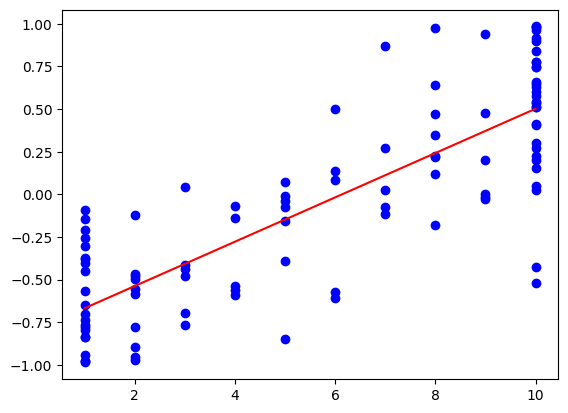

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(x=x, y=y, c="r")
ax.scatter(flatten_x, flatten_y, c="b")